In [1]:
# import packacges 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.stats import linregress
from scipy.optimize import curve_fit
from matplotlib.ticker import FormatStrFormatter
import ase


# Import Data 

In [2]:
import pandas as pd
import numpy as np

# Load the CSV file
file_path = 'data/aGC-DFT_data.csv'  # Replace with your actual file path
df = pd.read_csv(file_path)

# Convert each column into a nump array, removing NaN values
for col in df.columns:
    globals()[col] = df[col].dropna().to_numpy()  # Remove NaNs and convert to NumPy array

# Print the full DataFrame for verification
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.to_string())


    index          metal   fermi  dband_center  dband_width  d_band_filling  vac_E   bare_mu  bare_alpha      bare_E    no3_mu  no3_alpha     no3_q       no3_E    no3_G  tstate_mu  tstate_alpha  tstate_q    tstate_E  tstate_G  fstate_mu  fstate_alpha    fstate_E      o_mu   o_alpha         o_E     no2_q     h2o_q      oh_q      nh_q
0       0  saa_rh1cu_111 -0.3176     -1.558296     1.754135        0.886942  4.278  0.012532    2.820419 -113.064233  0.471479   3.102981 -0.288143 -137.517475 -137.274   0.316809      3.020287 -0.329207 -136.548700 -136.3430   0.484278      3.026494 -138.096666  0.126609  2.797283 -119.532412 -0.221637  0.131490 -0.173531 -0.257678
1       1  saa_ni1cu_111 -0.3775     -1.434713     1.559326        0.914765  4.198 -0.000439    2.804782 -111.298119  0.433115   3.071742 -0.312157 -135.878123 -135.635   0.157469      3.011083 -0.289971 -135.372400 -135.1630   0.406144      2.978924 -136.492408  0.109043  2.786988 -118.007766 -0.245814  0.122253 -0.181534 -0.31

In [3]:
# Read the CSV file
file_path = 'data/jdftx_data.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Convert each column into a NumPy array, removing NaN values
for col in df.columns:
    globals()[col] = df[col].dropna().to_numpy()  # Remove NaNs and convert to NumPy array

# Print the full DataFrame for verification
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.to_string())

    index  jpotential    jfermi  jbare_surf_charge      jbare_E  jno3_surf_charge       jno3_E       jno3_G  jtstate_surf_charge    jtstate_E    jtstate_G
0       0        -1.0 -0.134502         684.686707 -7267.561281        707.963249 -7325.760100 -7325.752309                  NaN          NaN          NaN
1       1        -0.8 -0.141852         684.440099 -7267.527223        707.780806 -7325.734891 -7325.725814                  NaN          NaN          NaN
2       2        -0.6 -0.149202         684.225441 -7267.495995        707.581343 -7325.705879 -7325.697648           707.350422 -7325.647379 -7325.641425
3       3        -0.4 -0.156552         684.031579 -7267.466392        707.408797 -7325.679517 -7325.669631           707.176091 -7325.620731 -7325.614704
4       4        -0.2 -0.163902         683.851003 -7267.437455        707.234327 -7325.651565 -7325.641826                  NaN          NaN          NaN
5       5         0.0 -0.171252         683.664482 -7267.406189       

# aGC-DFT Model

In [4]:
# missing indicies for dissociation barriers 
missing_data = [8, 12, 16]  

# reference states for calculation computed from VASP
hno3 = -27.63929776
hno3_G = -27.658
h2 = -6.99048756
h2_G = -7.259

# metal organization 
saa_111 = 4
pure_111 = 9
saa_100 = 13
pure_100 = 17

# model parameters
area = 23.71355 # surface area as calculated from ASE

# compute pzc from work function for each metal 
bare_pzc = vac_E - fermi - 4.66 # reference state of 4.66 to align with JDFTx 

# analytical grand canonical method 
def aGC_DFT(mu, alpha, E_dft, potential, d, e_r, slab_alpha=bare_alpha, U_pzc = bare_pzc): 
    epsilon = e_r * 0.0055 # convert relative permittivity to absolute permittivity

    if len(U_pzc) != len(E_dft):  # Remove the elements at the specified indices
        U_pzc = np.delete(U_pzc, missing_data)       
        slab_alpha = np.delete(slab_alpha, missing_data)
       
    U_lambda = U_pzc + mu / area / epsilon # compute shift in PZC 

    energy = [E_dft - (1/2 * epsilon * area / d) * (U - U_lambda)**2 + mu * (U - U_lambda) / d  + (alpha - slab_alpha) / 2 * ((U - U_lambda) / d)**2 for U in potential] # compute grand free energy 
    return np.vstack(energy).T

# no potential dependence
def null(mu, alpha, E_dft, potential, U_pzc = bare_pzc): 
    if len(U_pzc) != len(E_dft): 
        U_pzc = np.delete(U_pzc, missing_data) # Remove the elements at the specified indices
        #print('Deleted missing indices')
    energy = [E_dft - 0*U for U in potential] # compute E(U) = E_PZC at each potential 
    return np.vstack(energy).T

# Potential Dependence of Nitrate Adsorption over Cu(111): CHE vs aGC-DFT vs eGC-DFT

CHE electrosorption valency: -1.0 eV/V
aGC-DFT electrosorption valency: -0.6935185884854034 eV/V and R2 value: 0.9998710502212003
JDFTx electrosorption valency: -0.5818725483751717 eV/V and R2 value: 0.9987624744214504


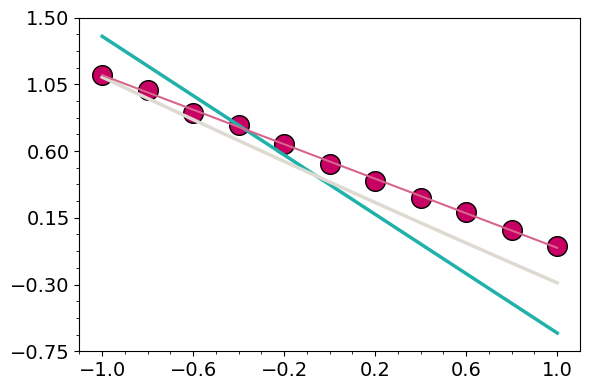

In [5]:
# potential range 
potential = np.arange(-1.0, 1.2, 0.2) # V vs SHE
U = potential

# compute grand free energies from analytical method 
gc_energy_bare = aGC_DFT(bare_mu, bare_alpha, bare_E, potential, 3, 78.4)
gc_energy_no3= aGC_DFT(no3_mu, no3_alpha, no3_G, potential, 3, 78.4) 

# compute no3 adsorption energy with both aGC-DFT 
no3_adsorption = gc_energy_no3 - (gc_energy_bare + hno3_G - 1/2 * h2_G) - U + 0.480
no3_ads_cu = no3_adsorption[4] 

#compute no3 adsorption enegry with CHE 
no3_adsorption_che = null(no3_mu, no3_alpha, no3_G, potential) - (null(bare_mu, bare_alpha, bare_E, potential) + hno3_G - 1/2 * h2_G) - U + 0.480
no3_ads_che_cu = no3_adsorption_che[4] 

#comptue no3 adsorption energy with jdftx 
# reference states for calculation computed from VASP
jhno3 = -58.735483320473485
jhno3_G = jhno3 + -0.013
jh2 = -1.177143541694519
jh2_G = jh2 + -0.039

jdftx_slab_n0 = 684
jdftx_slab_phi = (jbare_E - (jbare_surf_charge - jdftx_slab_n0) * jfermi)  
jdftx_ads_n0 = 707
jdftx_ads_phi = (jno3_G - (jno3_surf_charge - jdftx_ads_n0) * jfermi) 

jdftx_grand_energy = ((jdftx_ads_phi - (jdftx_slab_phi + jhno3_G - 1/2 * jh2_G)) * 27.2114 - jpotential) + 0.480

# Calculate the lines of best fit for (1) jdftx and aGC-DFT (assuming linear potential depedence)
jdftx_eval, jdftx_intercept, jdftx_r_value, _, _ = linregress(jpotential, jdftx_grand_energy) # compute electrosorption valencies 
aGC_eval, aGC_intercept, aGCr_value, _, _ = linregress(potential, no3_ads_cu) # compute electrosorption valencies 

print(f'CHE electrosorption valency: {-1.0} eV/V')
print(f'aGC-DFT electrosorption valency: {aGC_eval} eV/V and R2 value: {aGCr_value**2}')
print(f'JDFTx electrosorption valency: {jdftx_eval} eV/V and R2 value: {jdftx_r_value**2}')

# Create the scatter plot
plt.figure(figsize=(6, 4))

# Plot aGC_DFT vs potential
plt.plot(potential, no3_ads_che_cu, color="lightseagreen", linewidth=2.5)

# Plot aGC_DFT vs potential
plt.plot(potential, no3_ads_cu, color="#dedad2", linewidth=2.5)

# Plot jpotential vs potential
plt.scatter(jpotential, jdftx_grand_energy, color="#c80064", s=200, edgecolor='black')
plt.plot(potential, jdftx_eval * potential + jdftx_intercept, color="#d7658b", linestyle='-') 

# Add labels and legend
plt.xticks(np.arange(-1.0, 1.4, 0.4), fontsize=14)
plt.yticks(np.linspace(-0.75, 1.5, 6), fontsize=14)
#plt.ylim(None, 1.50)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# Show the plot
plt.tight_layout()
plt.savefig('figures/Eads(NO3)_che_aGC_eGC.svg', format='svg', dpi=300, bbox_inches='tight')

# NO3 Adsorption: Electrosorption Valencies vs Dipole Moment 

The R2 value of the fit is: 0.9897666736677625


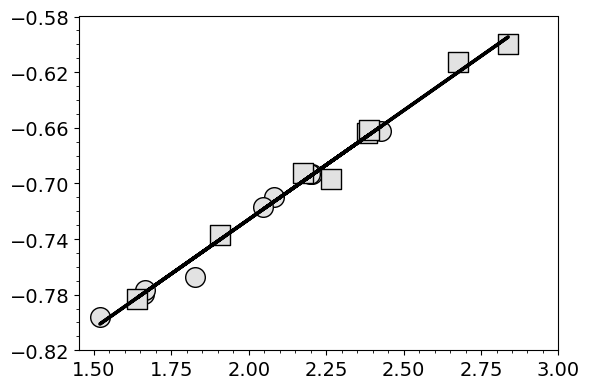

In [6]:
gc_energy_bare = aGC_DFT(bare_mu, bare_alpha, bare_E, potential, 3, 78.4) # compute grand free energy of bare slab 
gc_energy_no3= aGC_DFT(no3_mu, no3_alpha, no3_E, potential, 3, 78.4) # compute grand free energy of covered slab 

# computing adsorption energies 
no3_adsorption = gc_energy_no3 - (gc_energy_bare + hno3 - 1/2 * h2) - U # compute adsorption energy usign GC-DFT
electrosorption_v = []
r2_value = []

# calculate electrosorption valencies for each catalyst 
for metal in no3_adsorption: 
    slope, intercept, r_value, p_value, std_err = linregress(U, metal) # compute electrosorption valencies 
    electrosorption_v.append(slope)
    r2_value.append(r_value**2)
electrosorption_v = np.array(electrosorption_v) # store electrosorption valencies 

no3_dipole_shift = (no3_mu - bare_mu) * 4.803 # compute shift in dipole moment and covert ot Debye 
m, b, r_value, p_value, std_err = linregress(no3_dipole_shift, electrosorption_v) # fit electrosoprtion valency vs shift in dipole moment
# output R2 value 
print(f'The R2 value of the fit is: {r_value**2}')

## plot results ##
plt.figure(figsize=(6, 4))
plt.scatter(no3_dipole_shift[:saa_111] , electrosorption_v[:saa_111], color="#e2e2e2", s=200, edgecolors='black')
plt.scatter(no3_dipole_shift[saa_111:pure_111], electrosorption_v[saa_111:pure_111], color="#e2e2e2", s=200, edgecolors='black')
plt.scatter(no3_dipole_shift[pure_111:saa_100], electrosorption_v[pure_111:saa_100], color="#e2e2e2", s=200, marker='s', edgecolors='black')
plt.scatter(no3_dipole_shift[saa_100:], electrosorption_v[saa_100:], color="#e2e2e2", s=200, marker='s', edgecolors='black')
plt.plot(no3_dipole_shift, m * no3_dipole_shift + b, color='black', linewidth=2.5)

# plot formatting 
plt.yticks(np.linspace(-0.82, -0.58, 7), fontsize=14)
plt.xticks(np.linspace(1.5, 3, 7), fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# save plot 
plt.tight_layout()
plt.savefig('figures/dipole_moment_v_no3_electrosorption.svg')
    


# Dipole Moment vs Charge Transfer 

The R2 value of the fit is: 0.8035909218278297


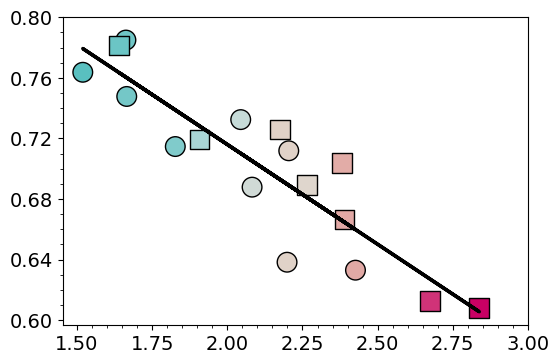

In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable

# Define custom colormap using the provided color codes
custom_colors = ["#54bebe", "#76c8c8", "#98d1d1", "#badbdb", "#dedad2", "#e4bcad", "#df979e", "#d7658b", "#c80064"]
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", custom_colors)

# Normalize the values for the colormap
norm = Normalize(vmin=-0.80, vmax=-0.60)
no3_delta_q = no3_q + 1 
m, b, r_value, p_value, std_err = linregress(no3_dipole_shift, no3_delta_q) # fit electrosoprtion valency vs shift in dipole moment
print(f'The R2 value of the fit is: {r_value**2}')
# Plot results
plt.figure(figsize=(6, 4))

sc = plt.scatter(
    no3_dipole_shift[:pure_111], no3_delta_q[:pure_111],
    c=electrosorption_v[:pure_111],  # Color based on electrosorption values
    cmap=custom_cmap,    # Use the custom colormap
    norm=norm,           # Apply normalization
    s=200,               # Marker size
    edgecolors='black',
    alpha=1         # Transparency
)

sc = plt.scatter(
    no3_dipole_shift[pure_111:pure_100], no3_delta_q[pure_111:pure_100],
    c=electrosorption_v[pure_111:pure_100],  # Color based on electrosorption values
    cmap=custom_cmap,    # Use the custom colormap
    norm=norm,           # Apply normalization
    marker='s',          # Square marker
    s=200,               # Marker size
    edgecolors='black',
    alpha=1          # Transparency
)
plt.plot(no3_dipole_shift, m * no3_dipole_shift + b, color='black', linewidth=2.5)

# Add a colorbar
#cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=custom_cmap))
#cbar.ax.tick_params(labelsize=14)  # Set font size of tick marks

# Plot formatting
plt.yticks(np.arange(0.60, 0.80, 0.04), fontsize=14)
plt.xticks(np.arange(0.30*5, 0.65*5, 0.05*5), fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# Save plot
plt.savefig('figures/dipole_moment_v_charge_transfer_dband.svg', format='svg', dpi=300)


# Density of States

In [8]:
def extract_dos(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Extract column headers from the first line
    headers = lines[0].strip().split()
    
    # Initialize dictionary to store columns
    data = {header: [] for header in headers}
    
    # Read the data lines
    for line in lines[1:]:
        values = line.strip().split()
        for header, value in zip(headers, values):
            data[header].append(float(value))
    
    # Initialize dictionary for summed data
    sum_keys = {'s': [], 'p': [], 'd': [], 'f': []}
    
    # Determine which columns to sum
    for key in sum_keys.keys():
        cols_to_sum = [col for col in headers if col.startswith(key)]
        
        # Sum the columns element-wise if they exist
        if cols_to_sum:
            sum_keys[key] = [sum(values) for values in zip(*(data[col] for col in cols_to_sum))]
            data[f'{key}_total'] = sum_keys[key]
    
    return data

def calculate_d_band_properties(energies, d_sum, spin_polarized=1):

    # Calculate the d-band center (energy-weighted average)
    numerator_center = np.trapz(energies * d_sum, x=energies)  # Integral of energy * DOS
    denominator = np.trapz(d_sum, x=energies)  # Integral of DOS
    d_band_center = numerator_center / denominator if denominator != 0 else None

    # Calculate the d-band width (second central moment, n=2)
    numerator_width = np.trapz(((energies - d_band_center) ** 2) * d_sum, x=energies)
    d_band_width = np.sqrt(numerator_width / denominator) if denominator != 0 else None

    return d_band_center, d_band_width

['Icon\r', 'acu_100.txt', 'acu_111.txt', 'bpd_100.txt', 'bpd_111.txt', 'cni_100.txt', 'cni_111.txt', 'dru_0001.txt', 'erh_100.txt', 'erh_111.txt']
: list index out of rangen


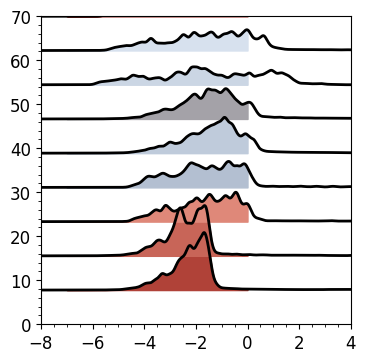

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import gaussian_filter1d


# Directory containing DOS files
directory = "data/pure_dos"  # Replace with the actual directory path

# Colors and offsets for stacking
colors = ["#d7e1ee", "#cbd6e4", "#a4a2a8","#bfcbdb", "#b3bfd1",  "#df8879", "#c86558", "#b04238", "#991f17"]
colors = colors[::-1]

vertical_offsets = np.linspace(0, 70, 10)  # Adjust spacing dynamically

# Create the plot
plt.figure(figsize=(4, 4))

# Iterate over all files in the directory
print(sorted(os.listdir(directory)))
for i, filename in enumerate(sorted(os.listdir(directory))):
    file_path = os.path.join(directory, filename)

    try:
        # Use extract_dos to parse the data
        data = extract_dos(file_path)

        x = np.array(data['#Energy'])  # Extract energy values
        y = gaussian_filter1d(np.array(data['d_total']), sigma=100)   # Extract total DOS
        
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue
    
    # Apply vertical offset
    y_offset = y + vertical_offsets[i]
    
    # Plot the DOS with offset
    plt.plot(x, y_offset, color='black', lw=2, label=filename)
    plt.fill_between(x, vertical_offsets[i], y_offset, where=(x > -7) & (x < 0), color=colors[(i) % len(colors)])

    
    # Calculate and mark the center point
    center, width = calculate_d_band_properties(x, np.array(data['d_total']))

# Format plot
plt.xlim(-8, 4)
plt.ylim(0,70)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# save plot
plt.savefig('figures/dos_plots_pm.svg', format='svg', dpi=300, bbox_inches='tight')


['Icon\r', 'apd1cu_100.txt', 'apd1cu_111.txt', 'bni1cu_111.txt', 'cni1cu_100.txt', 'crh1cu_100.txt', 'crh1cu_111.txt', 'dru1cu_100.txt', 'dru1cu_111.txt']
: list index out of rangen


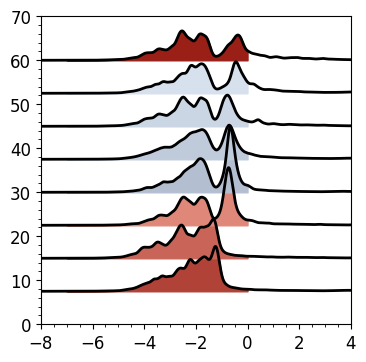

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.ndimage import gaussian_filter1d


# Directory containing DOS files
directory = "data/saa_dos"  # Replace with the actual directory path

# Colors and offsets for stacking
colors = ["#d7e1ee", "#cbd6e4", "#bfcbdb", "#b3bfd1",  "#df8879", "#c86558", "#b04238", "#991f17"]
colors = colors[::-1]

vertical_offsets = np.linspace(0, 60, len(os.listdir(directory)))  # Adjust spacing dynamically

# Placeholder Fermi energy for conditional shading
metal = [4, 13, 5, 14, 7, 6, 15] # Replace with actual value if known

# Create the plot
plt.figure(figsize=(4, 4))

# Iterate over all files in the directory
print(sorted(os.listdir(directory)))
for i, filename in enumerate(sorted(os.listdir(directory))):
    file_path = os.path.join(directory, filename)
     
    try:
        # Use extract_dos to parse the data
        data = extract_dos(file_path)

        x = np.array(data['#Energy'])  # Extract energy values
        y = gaussian_filter1d(np.array(data['d_total']), sigma=100)   # Extract total DOS
        
    except Exception as e:
        print(f"Error processing file {filename}: {e}")
        continue
    
    # Apply vertical offset
    y_offset = y + vertical_offsets[i]
    
    # Plot the DOS with offset
    plt.plot(x, y_offset, color='black', lw=2, label=filename)
    plt.fill_between(x, vertical_offsets[i], y_offset, where=(x > -7) & (x < 0), color=colors[(i) % len(colors)])

    
    # Calculate and mark the center point
    center, width = calculate_d_band_properties(x, np.array(data['d_total']))


# Format plot
plt.xlim(-8, 4)
plt.ylim(0,70)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# save plot
plt.savefig('figures/dos_plots_saa.svg', format='svg', dpi=300, bbox_inches='tight')


# CHE vs aGC-DFT: RMSE

0.48801488014880157


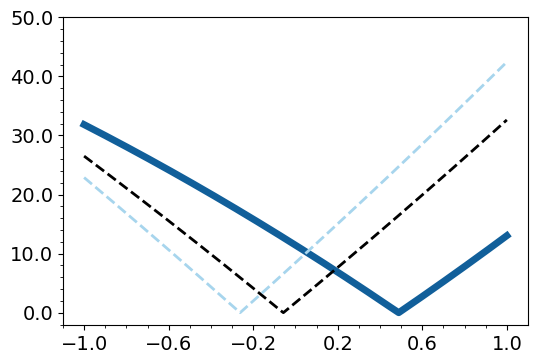

In [11]:
# compute grand free energies from analytical method 
potential = np.linspace(-1, 1, 100000)
U = potential

# List of e_r values
e_r_values = np.arange(2, 92, 10)

# Create an empty matrix for no3 adsorption energies
absolute_difference_tensor = np.zeros((7, len(e_r_values), len(potential))) 

# calculing no3 adsorption energy with the CHE model
no3_adsorption_che = null(no3_mu, no3_alpha, no3_E, potential) - (null(bare_mu, bare_alpha, bare_E, potential) + hno3 - 1/2*h2) - U

# compute adsorption energy for d = 3 and epsilion = 78.4 (normal)
gc_energy_bare = aGC_DFT(bare_mu, bare_alpha, bare_E, potential, 3, 78.4)
gc_energy_no3 = aGC_DFT(no3_mu, no3_alpha, no3_E, potential, 3, 78.4)
no3_adsorption = gc_energy_no3 - (gc_energy_bare + hno3 - 0.5 * h2) - U

# compute errors
ni1cu_111_error = np.abs(no3_adsorption.T[:, 5] - no3_adsorption_che.T[:,5]) * 96.48

print(potential[np.argmin(ni1cu_111_error)])
cu_error = np.abs(no3_adsorption.T[:, 4] - no3_adsorption_che.T[:, 4]) * 96.48
ni1cu_100_error = np.abs(no3_adsorption.T[:, 10] - no3_adsorption_che.T[:, 10]) * 96.48

result = ni1cu_100_error[np.isclose(potential, -0.60)]

## plot results ## 
plt.figure(figsize=(6, 4))
plt.plot(potential, ni1cu_111_error, color="#115f9a", linewidth=5) 
plt.plot(potential, cu_error, linestyle ="--", color="black", linewidth=2) 
plt.plot(potential, ni1cu_100_error, linestyle ="--", color="#a7d5ed", linewidth=2) 


plt.xticks(np.arange(-1, 1.4, 0.4), fontsize=14)
plt.yticks(np.linspace(0.0, 50, 6), fontsize=14)
#plt.ylim(None, 105)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# save plot
plt.savefig('figures/Eads(NO3)_RMSE_che_v_aGC.svg', format='svg', bbox_inches='tight')

# potential range 
potential = np.arange(-1.0, 1.1, 0.1) # V vs SHE
U = potential


In [12]:
print(bare_pzc)

print(bare_pzc + 3 / (4 * 78.4 * 0.0055 * area) * (no3_mu + bare_mu))

[-0.0644 -0.0845 -0.0296 -0.0817 -0.0904  0.4584  0.277   0.2086  0.2201
 -0.2187 -0.3004 -0.2234 -0.2758 -0.4294  0.226   0.2664  0.0144]
[-0.02889895 -0.05276425  0.00457456 -0.04443956 -0.05767113  0.4880226
  0.30056563  0.22965612  0.24579293 -0.17702609 -0.26214138 -0.18480852
 -0.2293962  -0.39010688  0.26004634  0.29078837  0.04320419]


[-50.84693087]
[5.13610172]
[[61.85046329 50.23416881 42.03356929 36.0536601  31.53110806]
 [25.03161907 19.11609581 15.45721978 12.97231822 11.17502892]
 [19.00908644 14.42748707 11.62391233  9.73210621  8.36967018]
 [14.28507781 10.79453161  8.67437245  7.25016991  6.22761066]
 [13.48048394 10.17933079  8.17656919  6.83219908  5.8674307 ]]


/var/folders/sl/r8hdl4bx3j9303t8kxh1v50w0000gn/T/ipykernel_17239/1208162963.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_matrix[i, j] = error  # Store error in matrix


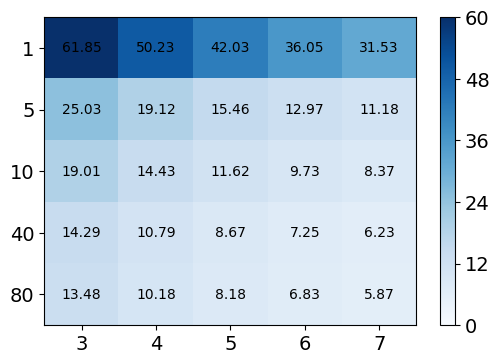

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Define the range of parameters
epsi = np.linspace(10, 80, 5, dtype=int)  # Ensures integer values
epsi = np.array([1, 5, 10, 40, 80])
d_thic = np.linspace(3, 7, 5, dtype=int)  # Ensures integer values

potential = np.array([-0.55])  # Single potential value
U = potential

# Initialize error matrix
error_matrix = np.zeros((len(epsi), len(d_thic)))

# Compute adsorption energy using the CHE model
no3_adsorption_che = null(no3_mu, no3_alpha, no3_E, potential) - (null(bare_mu, bare_alpha, bare_E, potential) + hno3 - 0.5 * h2) - U

# Iterate through each combination of epsi and d_thic
for i, e in enumerate(epsi):
    for j, d in enumerate(d_thic):
        gc_energy_bare = aGC_DFT(bare_mu, bare_alpha, bare_E, potential, d, e)
        gc_energy_no3 = aGC_DFT(no3_mu, no3_alpha, no3_E, potential, d, e)
        no3_adsorption = gc_energy_no3 - (gc_energy_bare + hno3 - 0.5 * h2) - U
        # Compute error
        error = np.abs(no3_adsorption.T[:, 1] - no3_adsorption_che.T[:, 1]) * 96.48
        error_matrix[i, j] = error  # Store error in matrix

        if e == 1 and d == 3:
            print(no3_adsorption.T[:, 1] * 96.48)

        if e == 80 and d == 7:
            print(no3_adsorption.T[:, 1] * 96.48)
        

print(error_matrix)
# Plot heatmap using only Matplotlib
plt.figure(figsize=(6, 4))

# Create the heatmap using imshow
cax = plt.imshow(error_matrix, cmap='Blues', interpolation='nearest', aspect='auto', vmin=0, vmax=60)

# Set tick labels and font size for x and y ticks
plt.xticks(ticks=np.arange(len(d_thic)), labels=d_thic, fontsize=14)
plt.yticks(ticks=np.arange(len(epsi)), labels=np.round(epsi, 1), fontsize=14)

# Add numerical labels to each box
for i in range(len(epsi)):
    for j in range(len(d_thic)):
        plt.text(j, i, f"{error_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)


# Add a colorbar with customized ticks
cbar = plt.colorbar(cax, pad=0.05)
cbar.set_ticks(np.linspace(0, 60, num=6))  # Create ticks from 0 to 60
cbar.ax.tick_params(labelsize=14)  # Set font size for color bar tick labels
cbar.ax.yaxis.label.set_fontsize(14)  # Set font size for color bar label

# Save and display plot
plt.savefig('figures/Eads(NO3)_RMSE_heatmap_matplotlib_only.svg', format='svg', bbox_inches='tight')
plt.show()


aGC-DFT electrosorption valency: -0.1748590908728897 eV/V and R2 value: 0.9998710502212003
JDFTx electrosorption valency: -0.24214147942359607 eV/V and R2 value: 0.9779553218938275
[0.448 0.448 0.448 0.448 0.448 0.448 0.448 0.448 0.448 0.448 0.448 0.448
 0.448 0.448 0.448 0.448 0.448 0.448 0.448 0.448 0.448]


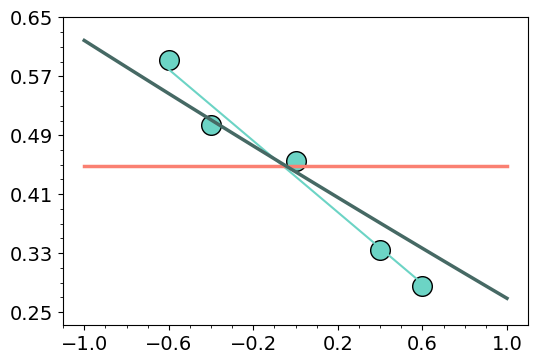

In [14]:
# potential range 
potential = np.arange(-1.0, 1.1, 0.1) # V vs SHE
U = potential

# comptue grand free energies of initial, transition, and final state 
gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_G, missing_data), potential, 3, 78.4)
gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_G, potential, 3, 78.4)

# compute grand free barriers using analytical method 
activation_barrier = gc_energy_trans - gc_energy_no3
activation_barrier_null = null(tstate_mu, tstate_alpha, tstate_G, potential) - null(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_G, missing_data), potential)
activation_barrier_null_cu = activation_barrier_null[4]
activation_barrier_cu = activation_barrier[4]

# compute grand free energies using the explicit method using explicir method 
jdftx_potential = np.array([-0.6, -0.4, 0.0, 0.4, 0.6])
j_potential = np.arange(-0.6, 0.7, 0.1)

jdftx_ads_n0 = 707
jdftx_ads_phi = (jno3_G - (jno3_surf_charge  - jdftx_ads_n0) * jfermi) 

# compute grand free energies using the explicit method using explicir method 
jdftx_tstate_n0 = 707
jdftx_tstate_phi = (jtstate_G  - (jtstate_surf_charge - jdftx_tstate_n0) * jfermi[[2, 3, 5, 7, 8]])  

jdftx_barrier_phi = (jdftx_tstate_phi - jdftx_ads_phi[[2, 3, 5, 7, 8]]) * 27.2114

# Calculate the lines of best fit for (1) jdftx and aGC-DFT (assuming linear potential depedence)
jdftx_m, jdftx_b, jdftx_r_value, _, _ = linregress(jdftx_potential, jdftx_barrier_phi) # compute electrosorption valencies 
aGC_eval, aGC_intercept, aGC_r_value, _, _ = linregress(potential, activation_barrier[4]) # compute electrosorption valencies 

print(f'aGC-DFT electrosorption valency: {aGC_eval} eV/V and R2 value: {aGCr_value**2}')
print(f'JDFTx electrosorption valency: {jdftx_m} eV/V and R2 value: {jdftx_r_value**2}')


# Create the scatter plot
plt.figure(figsize=(6, 4))

# Plot aGC_DFT vs potential
plt.scatter(jdftx_potential, jdftx_barrier_phi, color="#6cd4c5", s=200, edgecolor='black')
plt.plot(j_potential, jdftx_m * j_potential + jdftx_b,  color="#6cd4c5", linestyle='-') 
plt.plot(potential, activation_barrier_null_cu, color='salmon', linewidth=2.5)

print(activation_barrier_null_cu)

# Plot aGC_DFT vs potential
plt.plot(potential, activation_barrier_cu, color="#466964", linewidth=2.5)

plt.plot(potential, np.ones(len(potential)), color='white')


# Add labels and legend
plt.xticks(np.arange(-1.0, 1.4, 0.4), fontsize=14)
plt.yticks(np.linspace(0.25, 0.65, 6), fontsize=14)
plt.ylim(None, 0.65)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# Show the plot
plt.savefig('figures/Ebarrier_null_aGC_eGC.svg', format='svg', dpi=300, bbox_inches='tight')

# Potential Dependence of Nitrate Dissociation over Cu(111): CHE vs aGC-DFT vs eGC-DFT

# Potential Dependence vs Dipole Moment 

-0.14313819975175737
0.13800720586323634 -0.0006479540815426954


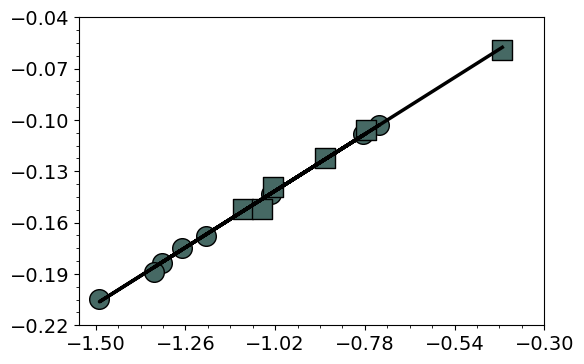

In [15]:
gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential,  3, 78.4)
gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_E, potential,  3, 78.4)

# calculing no3 adsorption energy with both models 
no3_barrier = gc_energy_trans - gc_energy_no3 
electrosorption_v = []
r2_value = []
# calculate electrosorption valencies for each catalyst 
for metal in no3_barrier: 
    slope, intercept, r_value, p_value, std_err = linregress(U, metal)
    electrosorption_v.append(slope)
    r2_value.append(r_value**2)
electrosorption_v = np.array(electrosorption_v) 
print(np.mean(electrosorption_v))
no3_dipole_shift = (tstate_mu - np.delete(no3_mu, missing_data)) * 4.803
m, b, r_value, p_value, std_err = linregress(no3_dipole_shift, electrosorption_v)
print(m, b)

## plot results ##
plt.figure(figsize=(6,4))
sc = plt.scatter(
    no3_dipole_shift[:8], electrosorption_v[:8],
    c="#466964",
    s=200,               # Marker size
    edgecolors='black',
    alpha=1         # Transparency
)

sc = plt.scatter(
    no3_dipole_shift[8:14], electrosorption_v[8:14],
    c="#466964",  # Color based on electrosorption values
    marker='s',          # Square marker
    s=200,               # Marker size
    edgecolors='black',
    alpha=1          # Transparency
)
plt.plot(no3_dipole_shift, m * no3_dipole_shift + b, color='black', linewidth=2.5)


# plot formatting
plt.yticks(np.linspace(-0.22, -0.04, 7), fontsize=14)
plt.xticks(np.linspace(-1.5, -0.3, 6), fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# Show plot
plt.savefig('figures/dipole_moment_v_barrier_poten_depnd.svg', format='svg', dpi=300, bbox_inches='tight')

# Change in Dipole Moment vs Charge Transfer

[-0.041064  0.022186  0.041935  0.034559  0.029998 -0.009407  0.051622
  0.050453 -0.016849 -0.043332  0.022572 -0.117545 -0.045879 -0.06512 ]
-0.07868672394754611 -0.08737643417473008
0.20242570526966278


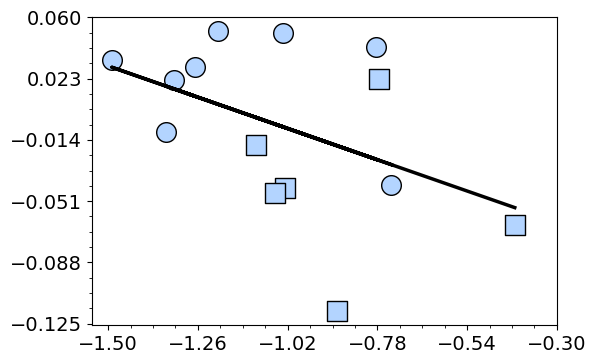

In [16]:
gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential,  3, 78.4)
gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_E, potential,  3, 78.4)

delta_q = tstate_q - np.delete(no3_q, missing_data)
print(delta_q)
no3_dipole_shift = (tstate_mu - np.delete(no3_mu, missing_data)) * 4.803
m, b, r_value, p_value, std_err = linregress(no3_dipole_shift, delta_q)

print(m,b)

print(r_value**2)

## plot results ##
plt.figure(figsize=(6,4))
sc = plt.scatter(
    no3_dipole_shift[:8], delta_q[:8],
    c="#b3d4ff",
    s=200,               # Marker size
    edgecolors='black',
    alpha=1         # Transparency
)

sc = plt.scatter(
    no3_dipole_shift[8:14], delta_q[8:14],
    c="#b3d4ff",
    s=200,  
    marker='s',           # Marker size
    edgecolors='black',
    alpha=1         # Transparency
)

plt.plot(no3_dipole_shift, m * no3_dipole_shift + b, color='black', linewidth=2.5)

# plot formatting
plt.yticks(np.linspace(-0.125, 0.06, 6), fontsize=14)
plt.xticks(np.linspace(-1.5, -0.3, 6), fontsize=14)
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# Show plot
plt.savefig('figures/barrier_dipole_moment_v_charge_transfer.svg', format='svg', dpi=300, bbox_inches='tight')

# aGC-DFT vs Null: RMSE

-0.3003999999999998
[4.97040585]


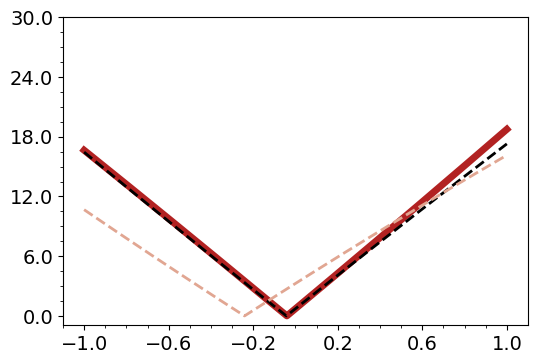

In [17]:
# compute grand free energies from analytical method 
potential = np.linspace(-1, 1, 100000)
U = potential

# compute grand free barriers and rwction energy 
activation_barrier_null = null(tstate_mu, tstate_alpha, tstate_E, potential) - null(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential)

# compute adsorption energy for d = 3 and epsilion = 78.4 (normal)
gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential, 3, 78.4)
gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_E, potential, 3,  78.4)
activation_barrier = gc_energy_trans - gc_energy_no3

# compute the error 
ni1cu_111_error = np.abs(activation_barrier.T[:, 1] - activation_barrier_null.T[:, 1]) * 96.48
cu_111_error = np.abs(activation_barrier.T[:, 4] - activation_barrier_null.T[:, 4]) * 96.48
ni1cu_100_error = np.abs(activation_barrier.T[:, 9] - activation_barrier_null.T[:, 9]) * 96.48

## plot results ## 
plt.figure(figsize=(6, 4))
plt.plot(potential, ni1cu_111_error, color="firebrick", linewidth=5) 
plt.plot(potential, cu_111_error, linestyle="--",  color="black", linewidth=2) 
plt.plot(potential, ni1cu_100_error, linestyle="--",  color="#e1a692", linewidth=2) 
print(bare_pzc[10])
result = ni1cu_100_error[np.isclose(potential, -0.60)]
print(result)


plt.xticks(np.arange(-1, 1.4, 0.4), fontsize=14)
plt.yticks(np.linspace(0.0, 30, 6), fontsize=14)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.minorticks_on()
plt.tick_params(axis='y', which='minor', length=2)  # Y-axis minor ticks
plt.tick_params(axis='x', which='minor', length=2)

# potential range 
potential = np.arange(-1.0, 1.1, 0.1) # V vs SHE
U = potential
plt.savefig('figures/barrier_RMSE_null_v_aGC.svg', format='svg', dpi=300, bbox_inches='tight')


[99.83779762]
[52.63114205]


/var/folders/sl/r8hdl4bx3j9303t8kxh1v50w0000gn/T/ipykernel_17239/2629955831.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  error_matrix[i, j] = error  # Store error in matrix


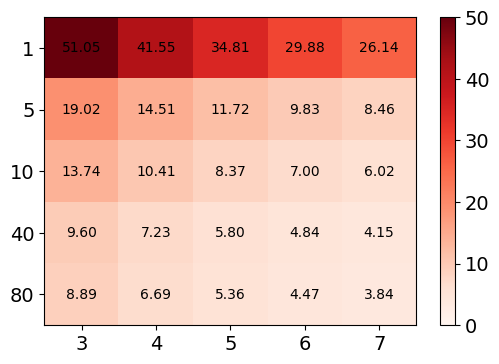

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Define the range of parameters
epsi = np.array([1, 5, 10, 40, 80])
d_thic = np.linspace(3, 7, 5, dtype=int)  # Ensures integer values

potential = np.array([-0.55])  # Single potential value
U = potential

# Initialize error matrix
error_matrix = np.zeros((len(epsi), len(d_thic)))

# Compute adsorption energy using the CHE model
activation_barrier_null = null(tstate_mu, tstate_alpha, tstate_E, potential) - null(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential)

# Iterate through each combination of epsi and d_thic
for i, e in enumerate(epsi):
    for j, d in enumerate(d_thic):
        gc_energy_no3 = aGC_DFT(np.delete(no3_mu, missing_data), np.delete(no3_alpha, missing_data), np.delete(no3_E, missing_data), potential, d, e)
        gc_energy_trans = aGC_DFT(tstate_mu, tstate_alpha, tstate_E, potential, d, e)
        activation_barrier = gc_energy_trans - gc_energy_no3
        error = np.abs(activation_barrier.T[:, 1] - activation_barrier_null.T[:,1]) * 96.48
        error_matrix[i, j] = error  # Store error in matrix



        if e == 1 and d == 3:
            print(activation_barrier.T[:, 1] * 96.48)

        if e == 80 and d == 7:
            print(activation_barrier.T[:, 1] * 96.48)

# Plot heatmap using Matplotlib only
plt.figure(figsize=(6, 4))

# Create the heatmap using imshow

cax = plt.imshow(error_matrix, cmap='Reds', interpolation='nearest', aspect='auto', vmin=0, vmax=50)

# Customize ticks and labels
plt.xticks(ticks=np.arange(len(d_thic)), labels=d_thic, fontsize=14)
plt.yticks(ticks=np.arange(len(epsi)), labels=np.round(epsi, 1), fontsize=14)

# Add numerical labels to each box
for i in range(len(epsi)):
    for j in range(len(d_thic)):
        plt.text(j, i, f"{error_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontsize=10)


cbar = plt.colorbar(cax, pad=0.05)
cbar.set_ticks(np.linspace(0, 50, num=6))  # Set ticks from 0 to 50
cbar.ax.tick_params(labelsize=14)  # Set font size for color bar tick labels
cbar.ax.yaxis.label.set_fontsize(14)  # Set font size for color bar label


# Save and display plot
plt.savefig('figures/Ebarrier(NO3)_RMSE_heatmap_matplotlib.svg', format='svg', bbox_inches='tight')
plt.show()
